In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time
from sklearn import preprocessing
import random

### Importing OTU table, normalization (change to relative abundances), set training and testing groups

In [2]:
# Import data into a pandas dataframe
otu_table = pd.read_csv('EGAD00001003453.otu_table.99.denovo', sep='\t', header=0, index_col=0)

#Transpose OTU table so that samples are rows and OTUs are columns
otu_table = otu_table.T

#Convert to relative abundances
#Normalize each person to 1 (change to relative abundances)
otu_table_normalized = otu_table.div(otu_table.sum(axis=1), axis=0)
print(otu_table_normalized)

OTU_ID  denovo7709  denovo5395  denovo11322  denovo44859  denovo44858  \
G37960    0.000000         0.0          0.0          0.0          0.0   
G37961    0.000000         0.0          0.0          0.0          0.0   
G37962    0.000000         0.0          0.0          0.0          0.0   
G37963    0.000000         0.0          0.0          0.0          0.0   
G37964    0.000000         0.0          0.0          0.0          0.0   
G37965    0.000000         0.0          0.0          0.0          0.0   
G37966    0.000000         0.0          0.0          0.0          0.0   
G37967    0.000000         0.0          0.0          0.0          0.0   
G37968    0.000000         0.0          0.0          0.0          0.0   
G37969    0.000000         0.0          0.0          0.0          0.0   
G37970    0.000000         0.0          0.0          0.0          0.0   
G37971    0.000000         0.0          0.0          0.0          0.0   
G37972    0.000000         0.0          0.0        

In [3]:
#Make training and testing sets (50/50 for now)

#Scramble existing table with hard-coded random seed
otu_table_normalized = otu_table_normalized.sample(frac=1, random_state=1)

#Make first half training and second half testing
total_people = otu_table_normalized.shape[0]
print(total_people)
midway = total_people/2
training_table = otu_table_normalized.iloc[0:int(midway)]
testing_table = otu_table_normalized.iloc[int(midway):]


1010


### Set conditions to test:

In [4]:
N = [5, 10, 50, 100, 250]
weight_setup = ['even', 'uneven_100x', 'uneven_10x', 'uneven_graduated']#, 'uneven_bins']
num_bins = 3

#Number of times to run each condition (N and weight setup)
num_repeats = 5

### Functions

In [5]:
def calculate_weights(n,weight):
    if weight == 'even':
        return [1/n]*n
    elif weight == 'uneven_100x':
        x = 1/(100 + (n-1))
        return [100*x] + [x]*(n-1)
    elif weight == 'uneven_10x':
        x = 1/(10 + (n-1))
        return [10*x] + [x]*(n-1)
    elif weight == 'uneven_graduated':
        decreasing_list = list(range(n,0,-1))
        return [x/sum(decreasing_list) for x in decreasing_list]
    #elif weight == 'uneven_bins':
        #n/

    

### Master loop

In [6]:
state = [[0]*len(N) for i in range(num_repeats)]
df_list = []

for i in range(num_repeats):
    for j, n in enumerate(N):
        #Keep track of random seeds used to generate N random samples from OTU table
        state[i][j] = random.getstate()
        #Generate random sample of size n
        random_sample = training_table.sample(n=n, replace=True)
        
        for m, weight in enumerate(weight_setup):
            #Set up actual weights
            weight_list = calculate_weights(n,weight)
            
            #Calculate weighted OTU table
            #weighted_table = [random_sample.iloc[i]*weight_list[i] for i in range(n)]
            for k in range(n):
                random_sample.iloc[k] = random_sample.iloc[k]*weight_list[k]
                
            #Calculate weighted mean
            indiv_series = random_sample.mean(axis=0)
            
            #Store data + info/metadata as pandas Series
            sample_name = str(n) + "_" + weight + "_" + str(i)
            sample_number = i*len(N)*len(weight_setup) + j*len(weight_setup) + m
            indiv_series.loc['sample_name'] = sample_name
            indiv_series.loc['N'] = n
            indiv_series.loc['weight_setup'] = weight
            indiv_series.loc['weight_vector'] = weight_list
            indiv_series.loc['random_seed'] = random.getstate()
            
            
            indiv_df = pd.DataFrame(indiv_series, columns=[str(sample_number)])
            #print(indiv_df)
            df_list.append(indiv_df)
            
final_matrix = pd.concat(df_list, axis=1)
print(final_matrix.tail())

                                                               0  \
OTU_ID                                                             
sample_name                                             5_even_0   
N                                                              5   
weight_setup                                                even   
weight_vector                          [0.2, 0.2, 0.2, 0.2, 0.2]   
random_seed    (3, (2147483648, 4242706402, 1270246769, 12492...   

                                                               1  \
OTU_ID                                                             
sample_name                                      5_uneven_100x_0   
N                                                              5   
weight_setup                                         uneven_100x   
weight_vector  [0.9615384615384616, 0.009615384615384616, 0.0...   
random_seed    (3, (2147483648, 4242706402, 1270246769, 12492...   

                                              

In [7]:
final_matrix = final_matrix.T

In [8]:
final_matrix.to_csv('final_matrix.csv')

In [9]:
final_matrix

OTU_ID,denovo7709,denovo5395,denovo11322,denovo44859,denovo44858,denovo41472,denovo41473,denovo41470,denovo41471,denovo41476,...,denovo22219,denovo22218,denovo43272,denovo32739,denovo32738,sample_name,N,weight_setup,weight_vector,random_seed
0,7.71069e-07,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,5_even_0,5,even,"[0.2, 0.2, 0.2, 0.2, 0.2]","(3, (2147483648, 4242706402, 1270246769, 12492..."
1,7.41413e-09,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,5_uneven_100x_0,5,uneven_100x,"[0.9615384615384616, 0.009615384615384616, 0.0...","(3, (2147483648, 4242706402, 1270246769, 12492..."
2,5.29581e-10,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,5_uneven_10x_0,5,uneven_10x,"[0.7142857142857142, 0.07142857142857142, 0.07...","(3, (2147483648, 4242706402, 1270246769, 12492..."
3,1.41222e-10,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,5_uneven_graduated_0,5,uneven_graduated,"[0.3333333333333333, 0.26666666666666666, 0.2,...","(3, (2147483648, 4242706402, 1270246769, 12492..."
4,3.58654e-07,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,10_even_0,10,even,"[0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, ...","(3, (2147483648, 4242706402, 1270246769, 12492..."
5,3.29041e-09,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,10_uneven_100x_0,10,uneven_100x,"[0.9174311926605505, 0.009174311926605505, 0.0...","(3, (2147483648, 4242706402, 1270246769, 12492..."
6,1.73179e-10,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,10_uneven_10x_0,10,uneven_10x,"[0.5263157894736842, 0.05263157894736842, 0.05...","(3, (2147483648, 4242706402, 1270246769, 12492..."
7,1.25949e-11,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,10_uneven_graduated_0,10,uneven_graduated,"[0.18181818181818182, 0.16363636363636364, 0.1...","(3, (2147483648, 4242706402, 1270246769, 12492..."
8,2.57364e-08,1.59938e-08,0,0,1.83272e-08,4.38553e-09,0,2.38681e-09,0,6.17408e-09,...,5.47353e-09,7.49991e-09,0,0,0,50_even_0,50,even,"[0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.02, 0.0...","(3, (2147483648, 4242706402, 1270246769, 12492..."
9,1.72727e-10,1.07341e-10,0,0,1.23001e-08,2.94331e-11,0,1.60188e-11,0,4.14368e-11,...,3.67351e-11,5.03349e-11,0,0,0,50_uneven_100x_0,50,uneven_100x,"[0.6711409395973155, 0.006711409395973154, 0.0...","(3, (2147483648, 4242706402, 1270246769, 12492..."


In [10]:
even_x = []
even_y = []
uneven_100x_x = []
uneven_100x_y = []
uneven_10x_x = []
uneven_10x_y = []
uneven_graduated_x = []
uneven_graduated_y = []

def set_up_coordinates(sample, x_list,y_list):
    x_list.append(sample['N'])
    y_list.append(sample[:sample.size-5].astype(bool).sum())

In [11]:
for index, row in final_matrix.iterrows():
    if row['weight_setup'] == 'even':
        set_up_coordinates(row, even_x, even_y)
    elif row['weight_setup'] == 'uneven_100x':
        set_up_coordinates(row, uneven_100x_x, uneven_100x_y)
    elif row['weight_setup'] == 'uneven_10x':
        set_up_coordinates(row, uneven_10x_x, uneven_10x_y)
    elif row['weight_setup'] == 'uneven_graduated':
        set_up_coordinates(row, uneven_graduated_x, uneven_graduated_y)

In [12]:
print(uneven_100x_y)
print(even_y)

[7899, 11345, 29131, 36774, 43373, 8156, 12385, 28554, 35386, 42859, 9736, 11159, 27663, 37515, 43065, 6967, 9605, 25276, 35235, 43219, 7202, 12472, 28343, 36207, 43682]
[7899, 11345, 29131, 36774, 43373, 8156, 12385, 28554, 35386, 42859, 9736, 11159, 27663, 37515, 43065, 6967, 9605, 25276, 35235, 43219, 7202, 12472, 28343, 36207, 43682]


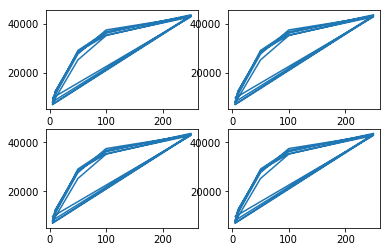

In [13]:
plt.subplot(2,2,1)
plt.plot(even_x, even_y)
plt.subplot(2,2,2)
plt.plot(uneven_100x_x,uneven_100x_y)
plt.subplot(2,2,3)
plt.plot(uneven_10x_x,uneven_10x_y)
plt.subplot(2,2,4)
plt.plot(uneven_graduated_x, uneven_graduated_y)
plt.show()